# Baseline Model based on U-Net

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

CURRENT_DIR = os.getcwd()
print(CURRENT_DIR)

/Users/jh/ai/courses/stanford/3-ML_RL/final_project/xcs229ii_final_project/code/notebooks


In [3]:
# needed to get the path right
os.chdir("..")

## Training

In [12]:
from baseline.trainer import Trainer
import segmentation_models as sm

model = sm.Unet(activation='sigmoid')
trainer = Trainer(model=model)

In [13]:
model = trainer.compile_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [14]:
%time history = trainer.train_from_simple_dataloader(identifier="00", dataset_size=10, batch_size=1, epochs=10)

Epoch 1/10
10/10 - 72s - loss: 1.4076 - iou_score: 0.1909 - f1-score: 0.3110 - f2-score: 0.3608 - recall: 0.4473 - precision: 0.2719 - val_loss: 1.4217 - val_iou_score: 0.2097 - val_f1-score: 0.3451 - val_f2-score: 0.3587 - val_recall: 0.3729 - val_precision: 0.3395
Epoch 2/10
10/10 - 63s - loss: 1.3081 - iou_score: 0.2220 - f1-score: 0.3522 - f2-score: 0.4066 - recall: 0.4998 - precision: 0.3096 - val_loss: 1.4093 - val_iou_score: 0.2180 - val_f1-score: 0.3560 - val_f2-score: 0.3778 - val_recall: 0.3991 - val_precision: 0.3379
Epoch 3/10
10/10 - 61s - loss: 1.2498 - iou_score: 0.2429 - f1-score: 0.3782 - f2-score: 0.4351 - recall: 0.5338 - precision: 0.3343 - val_loss: 1.4104 - val_iou_score: 0.2179 - val_f1-score: 0.3558 - val_f2-score: 0.3797 - val_recall: 0.4025 - val_precision: 0.3332
Epoch 4/10
10/10 - 64s - loss: 1.2012 - iou_score: 0.2621 - f1-score: 0.4017 - f2-score: 0.4620 - recall: 0.5665 - precision: 0.3552 - val_loss: 1.4050 - val_iou_score: 0.2218 - val_f1-score: 0.3609 

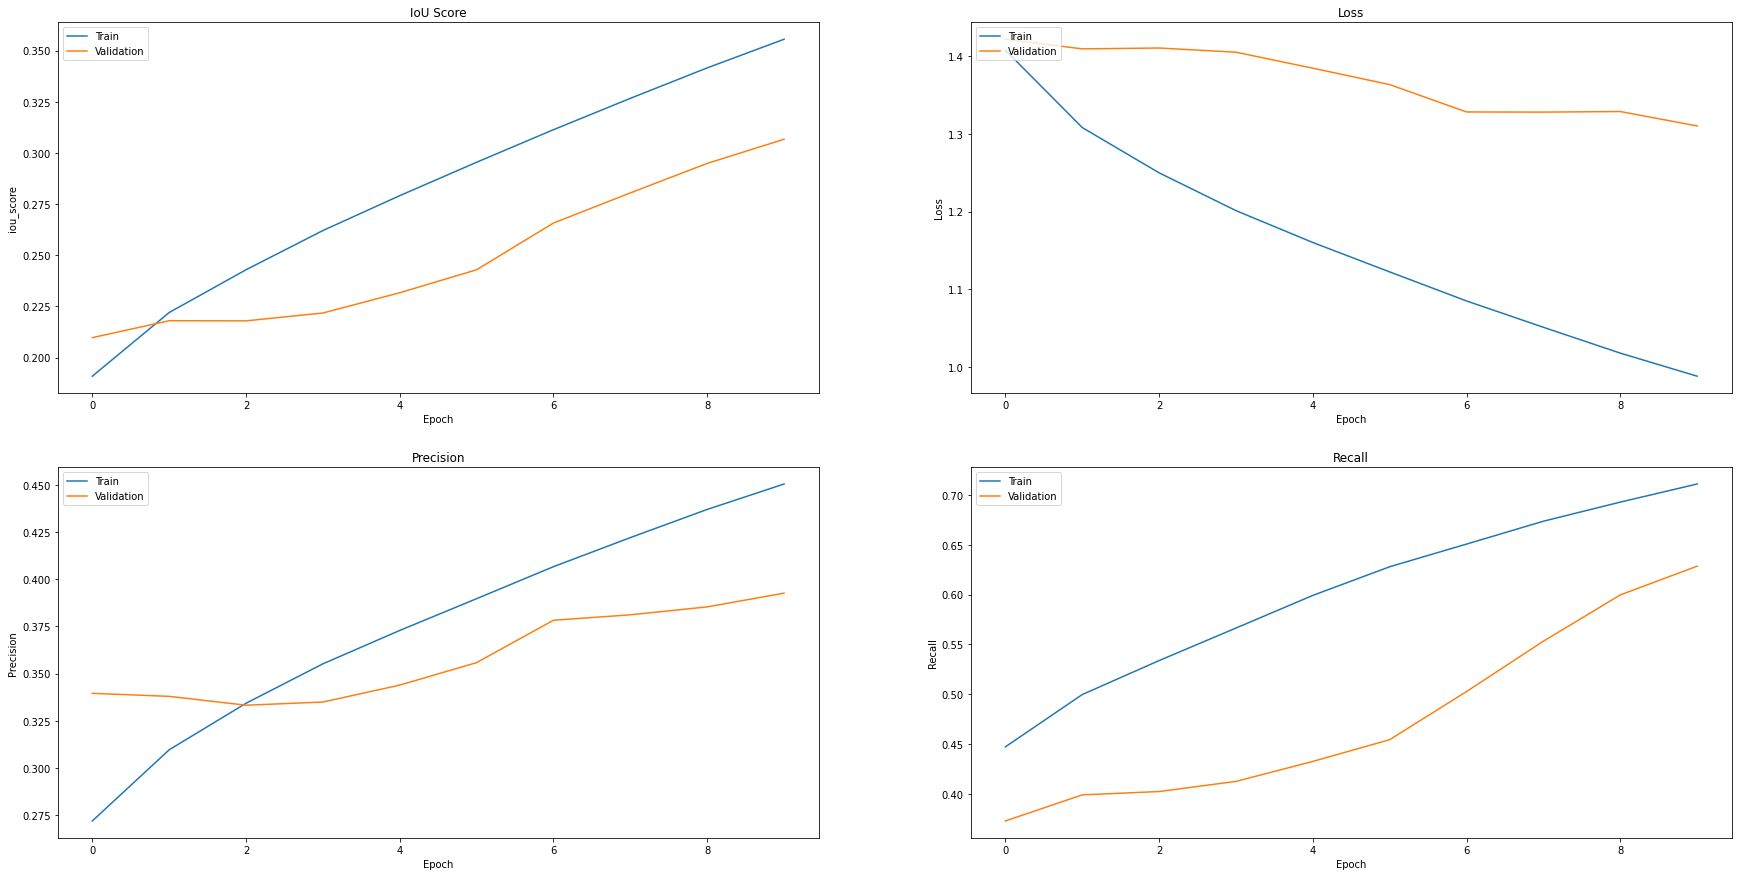

In [15]:
from utils.helper import Visualisation

Visualisation().plot_curves(history.history)

## Prediction

Run prediction on trained model.

### Helper methods

In [23]:
from utils.dataloader import SimpleDataLoader

def load_images(image_dir, load_masks=False, resize=True, size=None):
    simple_data_loader = SimpleDataLoader(
        backbone=Trainer.BACKBONE,
        images_folder_path=os.path.join(image_dir, "images"),
        masks_folder_path=os.path.join(image_dir, "masks"),
        resize_to=(512, 512),
        size=size
    )
    
    images = simple_data_loader.get_images()
    masks = None
    
    if load_masks:
        masks = simple_data_loader.get_masks()
        
    return images, masks


In [24]:
from utils.helper import Visualisation

def plot_images_masks(model, images, masks=None):
    for index, image in enumerate(images):
        image = np.expand_dims(image, axis=0)
        print(f"Image shape: {image.shape}")

        predicted_mask = model.predict(image).round()
        print(f"Predicted mask shape: {predicted_mask.shape}")
        
        mask = None
        
        if masks is not None:
            mask = masks[index]
            print(f"Mask shape: {mask.shape}")
        
        if mask is None:
            Visualisation().plot_images(
                image=image.squeeze(),
                predicted_mask=predicted_mask.squeeze(axis=0)
            )
        else:
            Visualisation().plot_images(
                image=image.squeeze(),
                predicted_mask=predicted_mask.squeeze(axis=0),
                mask=mask.squeeze()
            )

In [25]:
from constants import TRAIN_DIR

train_images, train_masks = load_images(TRAIN_DIR, load_masks=True, size=5)

(512, 512, 3)
(1, 512, 512, 3)


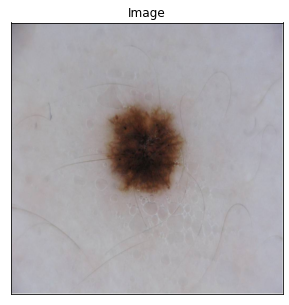

In [26]:
import numpy as np

train_image = train_images[1]

print(train_image.shape)
train_image = np.expand_dims(train_image, axis=0)  # add batch dimension
print(train_image.shape)

Visualisation().plot_images(image=train_image.squeeze())

In [27]:
model.load_weights(os.path.join("baseline", "export", "experiment_00_baseline.h5"))

In [28]:
predicted_mask = model.predict(train_image).round()
print(predicted_mask.shape)

(1, 512, 512, 1)


In [29]:
predicted_mask.squeeze(axis=0).shape

(512, 512, 1)

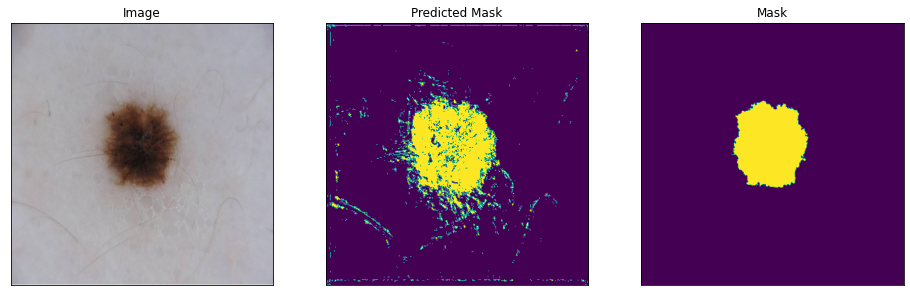

In [30]:
Visualisation().plot_images(
    image=train_image.squeeze(),
    predicted_mask=predicted_mask.squeeze(axis=0),
    mask=train_masks[1]
)

Image shape: (1, 512, 512, 3)
Predicted mask shape: (1, 512, 512, 1)
Mask shape: (512, 512, 1)


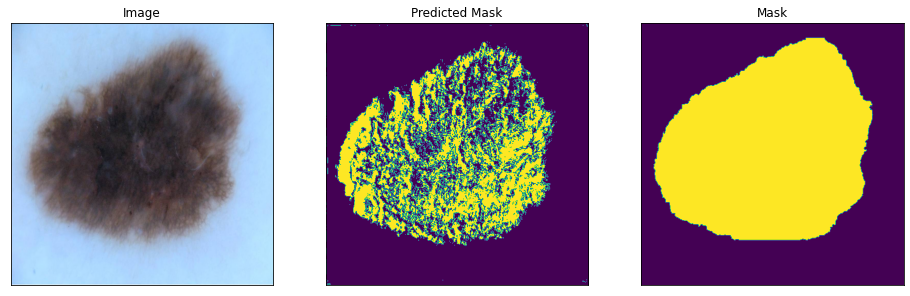

Image shape: (1, 512, 512, 3)
Predicted mask shape: (1, 512, 512, 1)
Mask shape: (512, 512, 1)


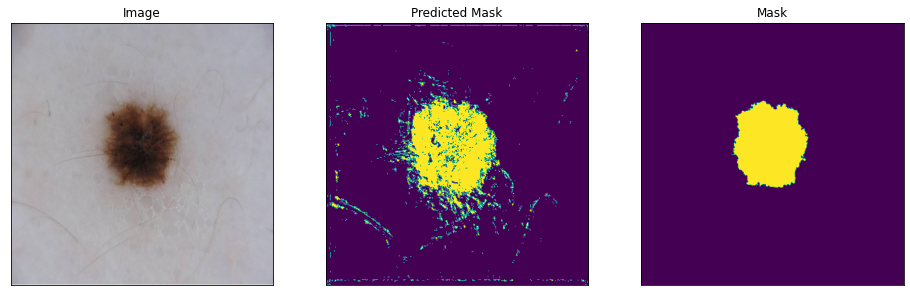

Image shape: (1, 512, 512, 3)
Predicted mask shape: (1, 512, 512, 1)
Mask shape: (512, 512, 1)


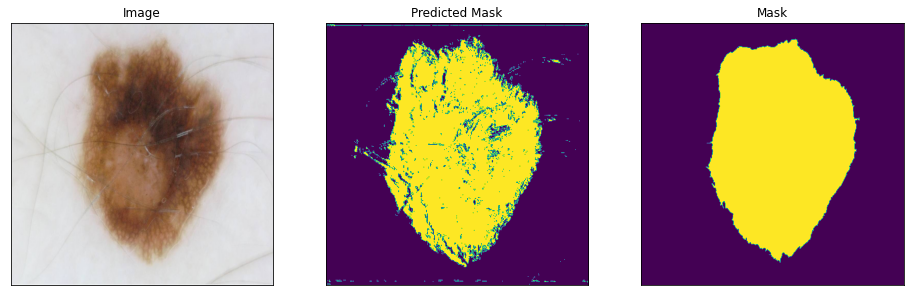

Image shape: (1, 512, 512, 3)
Predicted mask shape: (1, 512, 512, 1)
Mask shape: (512, 512, 1)


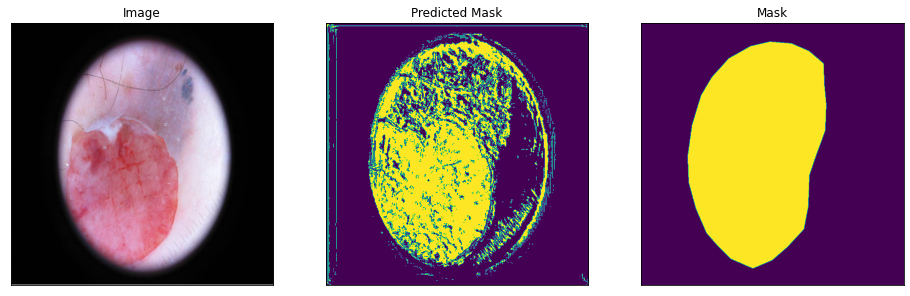

Image shape: (1, 512, 512, 3)
Predicted mask shape: (1, 512, 512, 1)
Mask shape: (512, 512, 1)


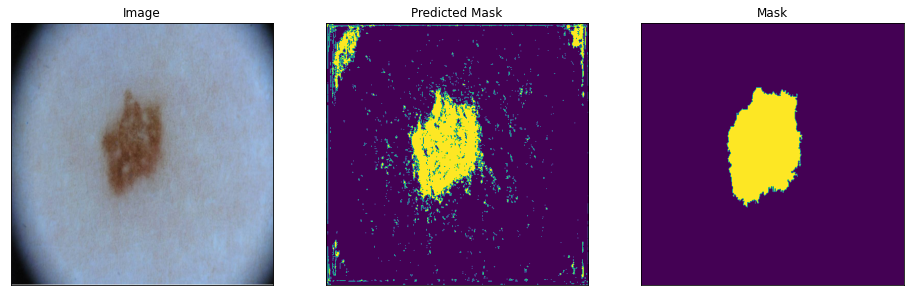

In [31]:
plot_images_masks(model, train_images, train_masks)

### From Azure Instance

In [ ]:
from utils.helper import Visualisation
import pickle
import os

AZURE_PATH = os.path.join("baseline", "export", "azure")

azure_hitory_path = os.path.join(AZURE_PATH, "train_history.pkl")
azure_history = pickle.load(open(azure_hitory_path, "rb"))
Visualisation().plot_curves(azure_history)

#### Train Images

In [ ]:
from baseline.trainer import Trainer

trainer = Trainer()
azure_model = trainer.get_model()
azure_model.load_weights(os.path.join(AZURE_PATH, "baseline.h5"))

In [ ]:
plot_images_masks(azure_model, train_images, train_masks)

#### Validation Images

In [ ]:
from constants import VALIDATION_DIR

validation_images, validation_masks = load_images(VALIDATION_DIR, load_masks=True)

In [ ]:
plot_images_masks(azure_model, validation_images[:5], validation_masks[:5])

##### Full Size Images

In [ ]:
from constants import VALIDATION_DIR

validation_images, validation_masks = load_images(VALIDATION_DIR, load_masks=True, resize=False, size=5)

In [ ]:
from utils.helper import Visualisation

index = 4

image = validation_images[index]
image = np.expand_dims(image, axis=0)
print(image.shape)

Visualisation().plot_images(
    image=image.squeeze(),
    predicted_mask=azure_model.predict(image).round().squeeze(axis=0),
    mask=validation_masks[index].squeeze()
)

In [ ]:
plot_images_masks(azure_model, validation_images, validation_masks)

#### Test Images (Unseen)

In [ ]:
from constants import TEST_DIR

train_images, _ = load_images(TEST_DIR, load_masks=True, size=5)

In [ ]:
plot_images_masks(azure_model, train_images)

### Calculate Metrics

This metric calculation is based on the [umetrics library](https://github.com/quantumjot/unet_segmentation_metrics).

The calculation uses the jaccard index threshold from the dataset description [landing page](https://challenge2018.isic-archive.com/task1/), section `metrics`, which is `0.65`.

In [ ]:
from constants import VALIDATION_DIR

validation_images, validation_masks = load_images(VALIDATION_DIR, load_masks=True)

In [ ]:
from utils.metrics import Metrics

metrics = Metrics().calculate(
    model=azure_model,
    images=validation_images,
    masks=validation_masks
)

print(metrics)